In [3]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import skimage
from skimage.transform import resize
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from keras import utils, callbacks
from tensorflow.keras import utils
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import layers, models
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from keras.losses import CategoricalCrossentropy
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn import metrics
from keras.models import model_from_json

**Download dataset from kaggle**

1. Go to your account, Scroll to API section and Click Expire API Token to remove previous tokens

2. Click on Create New API Token - It will download kaggle.json file on your machine

In [4]:
! pip install -q kaggle

In [2]:
from google.colab import files
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

In [9]:
!kaggle datasets download -d prekshapalva/indian-sign-language

100% 3.58G/3.59G [03:20<00:00, 19.9MB/s]
100% 3.59G/3.59G [03:20<00:00, 19.2MB/s]


In [ ]:
! unzip indian-sign-language.zip

In [11]:
train_folder = './Dataset'
all_data = []
for folder in os.listdir(train_folder):
    label_folder = os.path.join(train_folder, folder)
    onlyfiles = [{'label':folder,'path':os.path.join(label_folder, f)} for f in os.listdir(label_folder) if os.path.isfile(os.path.join(label_folder, f))]
    #print(onlyfiles)
    all_data += onlyfiles
data_df = pd.DataFrame(all_data)
data_df

,label,path
0,O,./Dataset/O/Image_1679049239.2705286.jpg
1,O,./Dataset/O/Image_1679049218.7128675.jpg
2,O,./Dataset/O/Image_1679049208.0653517.jpg
3,O,./Dataset/O/Image_1679049124.2362335.jpg
4,O,./Dataset/O/Image_1679049183.452729.jpg
...,...,...
53507,L,./Dataset/L/Image_1679047247.4989226.jpg
53508,L,./Dataset/L/Image_1679047241.894219.jpg
53509,L,./Dataset/L/Image_1679047220.3780713.jpg
53510,L,./Dataset/L/Image_1679047239.2050035.jpg


No charts were generated by quickchart


from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  from matplotlib import pyplot as plt
  import seaborn as sns
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_2['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

In [13]:
x_train,x_test = train_test_split(data_df, test_size= 0.10, random_state=42,stratify=data_df[['label']])
x_train,x_val = train_test_split(x_train, test_size= 0.20, random_state=42,stratify=x_train[['label']])

print (f'Train data shape : {x_train.shape} \nTest data shape : {x_test.shape} \nValidate data shape : {x_val.shape}')

Train data shape : (38528, 2) 
Test data shape : (5352, 2) 
Validate data shape : (9632, 2)


In [14]:
img_width, img_height = 64, 64
batch_size = 128
y_col = 'label'
x_col = 'path'
no_of_classes = len(data_df[y_col].unique())

print (f'Number of classes : {no_of_classes}')

train_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=x_train,x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height),class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

validation_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=x_val, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=True, zoom_range=0.2,shear_range=0.2)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=x_test, x_col=x_col, y_col=y_col,
    target_size=(img_width, img_height), class_mode='categorical', batch_size=batch_size,
    shuffle=False
)

Number of classes : 26
Found 38528 validated image filenames belonging to 26 classes.
Found 9632 validated image filenames belonging to 26 classes.
Found 5352 validated image filenames belonging to 26 classes.


In [15]:
base_model = ResNet50V2(input_shape=(64,64,3), weights='imagenet', include_top=False)

94668760/94668760 [==============================] - 5s 0us/step


In [16]:
base_model.trainable = False

In [17]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 70, 70, 3)            0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 32, 32, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 34, 34, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

In [19]:
flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(512, activation='relu')
dropout_layer_1 = layers.Dropout(0.5)
dense_layer_2 = layers.Dense(512, activation='relu')
dropout_layer_2 = layers.Dropout(0.5)
prediction_layer = layers.Dense(no_of_classes, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer_1,
    dense_layer_2,
    dropout_layer_2,
    prediction_layer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2, 2, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               4194816   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 26)               

In [20]:
epochs = 10
learning_rate = 0.0001

adam = Adam(lr=learning_rate)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(train_generator,
                    epochs=epochs,
                    verbose=1,
                    validation_data=validation_generator,
                    shuffle=True)

Epoch 1/10
301/301 [==============================] - 218s 680ms/step - loss: 0.4354 - accuracy: 0.8774 - val_loss: 0.0574 - val_accuracy: 0.9817
Epoch 2/10
301/301 [==============================] - 184s 612ms/step - loss: 0.1425 - accuracy: 0.9590 - val_loss: 0.0361 - val_accuracy: 0.9880
Epoch 3/10
301/301 [==============================] - 181s 602ms/step - loss: 0.1330 - accuracy: 0.9621 - val_loss: 0.0317 - val_accuracy: 0.9892
Epoch 4/10
301/301 [==============================] - 176s 585ms/step - loss: 0.0979 - accuracy: 0.9724 - val_loss: 0.0322 - val_accuracy: 0.9881
Epoch 5/10
301/301 [==============================] - 178s 592ms/step - loss: 0.1084 - accuracy: 0.9714 - val_loss: 0.0295 - val_accuracy: 0.9897
Epoch 6/10
301/301 [==============================] - 177s 589ms/step - loss: 0.0899 - accuracy: 0.9753 - val_loss: 0.0222 - val_accuracy: 0.9922
Epoch 7/10
301/301 [==============================] - 176s 585ms/step - loss: 0.0756 - accuracy: 0.9797 - val_loss: 0.0200 -

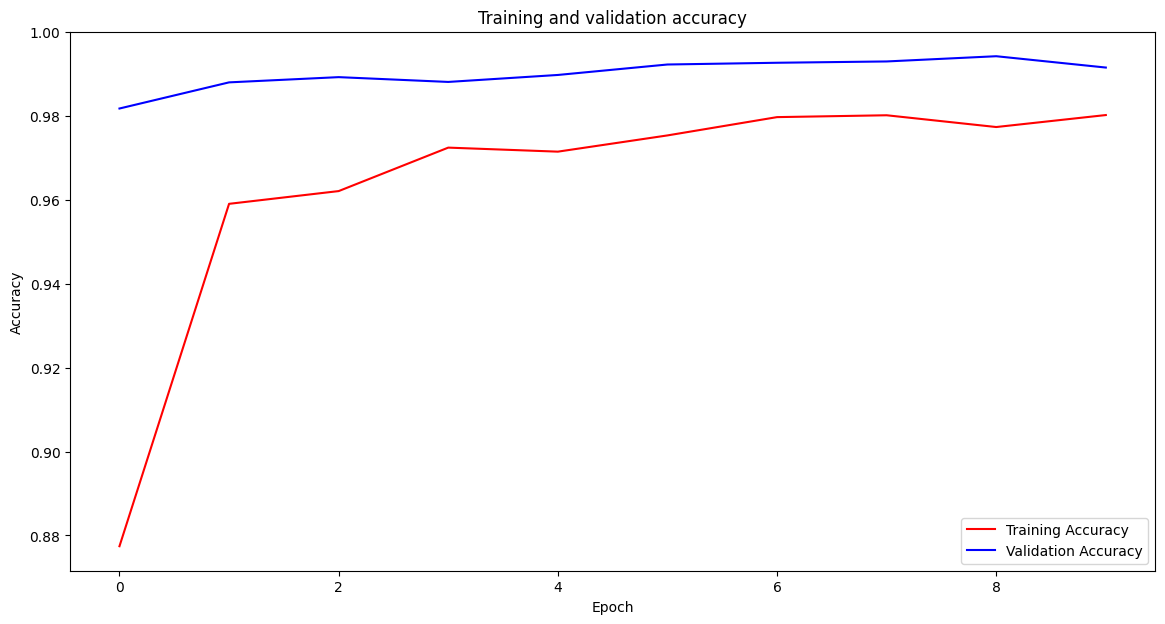

In [21]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

fig = plt.figure(figsize=(14,7))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss')

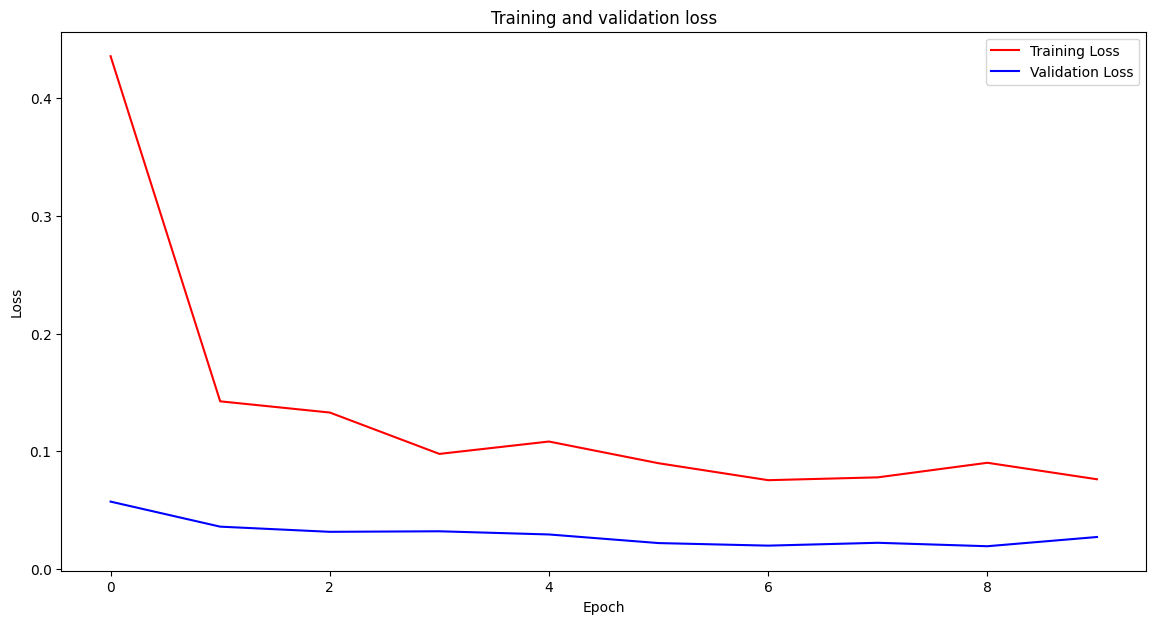

In [22]:
fig = plt.figure(figsize=(14,7))
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')

In [23]:
print(list(test_generator.class_indices.keys()))

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [24]:
predictions = model.predict(test_generator, verbose=1)
# Get most likely class
predicted_classes = np.argmax(predictions, axis=-1)
predictions = np.argmax(predictions, axis=-1) #multiple categories

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

42/42 [==============================] - 27s 594ms/step
              precision    recall  f1-score   support

           A       1.00      1.00      1.00       200
           B       1.00      0.99      1.00       200
           C       1.00      1.00      1.00       200
           D       1.00      0.99      0.99       200
           E       0.99      0.99      0.99       200
           F       1.00      1.00      1.00       200
           G       1.00      1.00      1.00       200
           H       1.00      1.00      1.00       200
           I       1.00      1.00      1.00       200
           J       0.99      0.99      0.99       200
           K       1.00      0.99      1.00       200
           L       0.99      1.00      1.00       200
           M       1.00      1.00      1.00       200
           N       0.94      0.99      0.96       215
           O       0.98      1.00      0.99       214
           P       0.96      1.00      0.98       205
           Q       1.00  

In [25]:
model.save('saved_model/ResNet50V2')